In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append("/workspaces/MambaLinearCode")
os.chdir("/workspaces/MambaLinearCode")


In [2]:
from configuration import Code, Config
from dataset import get_generator_and_parity
import torch
import os
import logging

def code_from_hint(hint,):
    code_files = os.listdir(CODES_PATH)
    code_files = [f for f in code_files if hint in f][0]
    print(code_files)
    code_n = int(code_files.split('_')[1][1:])
    code_k = int(code_files.split('_')[-1][1:].split('.')[0])
    code_type = code_files.split('_')[0]
    code = Code(code_n, code_k, code_type)
    return code


CODES_PATH = "codes/"
example_code = code_from_hint("LDPC_N49_K24")
G,H = get_generator_and_parity(example_code, standard_form=True)
example_code.generator_matrix = torch.from_numpy(G).transpose(0,1).long()
example_code.pc_matrix = torch.from_numpy(H).long()



config = Config(
    code=example_code,
    d_model=16,
    d_state=64,
    N_dec=8,
    lr=20e-4,
    eta_min=1e-8,
    batch_size=64,
    epochs=1000
)

OUTPUT_PATH = f".output-ssm-sub/.output-N-{config.N_dec}-d-{config.d_model}"

config.path = OUTPUT_PATH


os.makedirs(OUTPUT_PATH, exist_ok=True)
handlers = [
        logging.FileHandler(os.path.join(OUTPUT_PATH, 'logging.txt')),
        logging.StreamHandler()
    ]
logging.basicConfig(level=logging.INFO, format='%(message)s',
                    handlers=handlers)

LDPC_N49_K24.alist


In [3]:
from dataset import EbN0_to_std, ECC_Dataset, bin_to_sign, sign_to_bin
code = config.code 
EbNo_range_train = [5]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
x = torch.zeros_like(x)
random_indices = torch.randint(0, x.shape[0], (1,))
y = bin_to_sign(x)
y[0] *= -1
syn = torch.matmul(code.pc_matrix.float(), sign_to_bin(torch.sign(y))) % 2

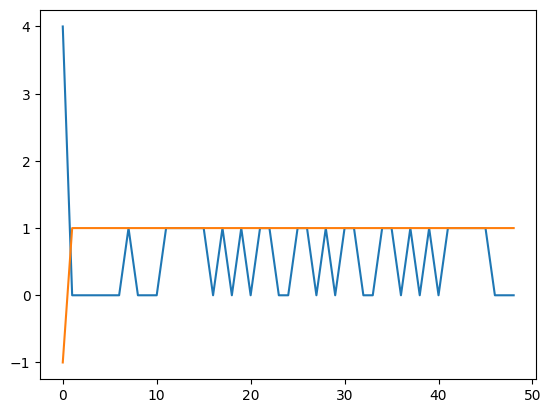

In [4]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(code.pc_matrix.T.float() @ syn)
plt.plot(y)

In [5]:
def embed(x, adjecancy, embedding):
    """
    x: input - (b,l)
    pc_matrix - (p,l)
    embedding - (l,d)

    output
    ------
    X: (b,l,p,d)
    """
    e = embedding
    m = adjecancy.unsqueeze(-1)
    me = (m*e).swapaxes(0,1)
    X = x.view(-1,x.shape[-1]).unsqueeze(-1).unsqueeze(-1)*me
    return X
print(embed(
    torch.tile(y,(2,1)),
    config.code.pc_matrix,
    embedding=torch.ones((len(y),3))
).shape)
embed(
    torch.tile(syn,(2,1)),
    torch.eye(len(syn)),
    embedding=torch.ones((len(syn),3))
).shape

torch.Size([2, 49, 28, 3])


torch.Size([2, 28, 28, 3])

In [6]:
import torch.nn.functional as F
from torch.nn import LayerNorm
from configuration import Config
import torch



class EncoderLayer(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.seq_len = config.code.n
        self.pc_len = config.code.pc_matrix.shape[0]
        self.d_model = config.d_model
        
        self.activation = F.silu
        self.norm = LayerNorm((self.d_model,))
        self.in_proj = torch.nn.Linear(self.d_model, self.d_model)
        self.out_proj = torch.nn.Linear(self.d_model, self.d_model)
        
        self.register_buffer("inner_pc_matrix", config.code.pc_matrix.T.unsqueeze(-1).float())
        
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.kaiming_uniform_(p)
        
        self.A_weights = torch.nn.Parameter(torch.randn(self.d_model, self.d_model) * 0.1)
        self.B_weights = torch.nn.Parameter(torch.randn(self.d_model, self.d_model)* 0.1)
        self.C_weights = torch.nn.Parameter(torch.randn(self.d_model, self.d_model)* 0.1)
        self.syn_h_weights = torch.nn.Parameter(torch.randn(1, self.pc_len)* 0.1)
        self.syn_B_weights = torch.nn.Parameter(torch.randn(self.seq_len, self.pc_len)* 0.1)
        
        
    
    def _ssm_calc(self, X, syn, h=None):
        """
        X: (b, l, p, d)
        syn: (b, p, d)

        where:
        b - Batch
        l - Length
        p - PC check count
        d - model dimension
        """

        y = torch.zeros_like(X)
        states = torch.zeros_like(X)
        A = F.sigmoid(torch.matmul(X, self.A_weights)) # (B, l, p , d)
        B = torch.matmul(X, self.B_weights) + torch.einsum("lc, bcpd->blpd", self.syn_B_weights, syn) * self.inner_pc_matrix # (B, l, p, d)
        C = torch.matmul(X, self.C_weights) * self.inner_pc_matrix # (B, l, p, d)
        h = torch.einsum("lc,bcpd->blpd", self.syn_h_weights, syn).squeeze(1) # (B, 1, p, d)
        
        for i in range(self.seq_len):
            h = A[...,i,:,:] * h + B[...,i,:,:] * X[...,i,:,:]
            states[...,i,:,:] = h
            y[...,i,:,:] = C[...,i,:,:] * h
        
        return y, A, B, C , states

    def _forward_pass(self, X, syn, h=None):
        return self._ssm_calc(X, syn, h)
    
    def _reverse_pass(self, X, syn ,h=None):# -> tuple[Tensor, Any, Any, float | Any]:
        r = self._ssm_calc(torch.flip(X,[1]), syn, h)
        return tuple(torch.flip(M,[1]) for M in r)
    
    def _bider_pass(self, X, syn, h=None):
        y1,A1,B1,C1,h1 = self._forward_pass(X,syn,h)
        y2,A2,B2,C2,h2 = self._reverse_pass(X,syn,h)
        return y1, y2, A1, B1, C1, h1
    
    def activate(self, out,):
        out_activated = self.activation(out,)
        return self.norm(out_activated)
        
    def forward(self, X, syn, h=None):
        """
        X: (b, l, p, d)
        syn: (b, p , p, d)

        where:
        b - Batch
        l - Length
        p - PC check count
        d - model dimension
        """
        X = self.in_proj(X)
        y1,y2,*rest = self._bider_pass(X, syn,h)
        out = y1+y2
        out = self.out_proj(out)
        out = self.activate(out)
        return  out
        
    
    

In [7]:
from torch.nn import ModuleList
from einops import rearrange

class ECCM(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.n = config.code.n
        self.seq_len = self.n
        self.pc_len = config.code.pc_matrix.size(0)
        self.d_model = config.d_model
        self.register_buffer("pc_matrix", config.code.pc_matrix)
        self.register_buffer("syndrome_connections", torch.eye(self.pc_len))
        self.resize_output_dim = torch.nn.Linear(self.pc_len*self.d_model, 1)
        

        self.x_embedding = torch.nn.Parameter(torch.zeros(self.seq_len,self.d_model))
        self.syn_embedding = torch.nn.Parameter(torch.zeros(self.pc_len,self.d_model))
        
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

        self.mamba: ModuleList = ModuleList([EncoderLayer(config,) for _ in range(config.N_dec)])
        self.activation = F.relu
    
    def forward(self, x, syndrome):
        """
        x: (b,l)
        syndrome: (b,p)
        """
        x= -torch.log(x + 1e-9)
        x = embed(x, self.pc_matrix, self.x_embedding )
        syndrome = embed(syndrome, self.syndrome_connections, self.syn_embedding)
        h = x
        for sublayer in self.mamba:
            h = h + sublayer.forward(h, syndrome)
        out = h
        out = self.resize_output_dim(
            rearrange(out, "b l p d -> b l (p d)")
        ).squeeze(-1) # (b l)
        return out

    def loss(self, out, err, y):
        loss = F.binary_cross_entropy_with_logits(
            out, err)
        x_pred = sign_to_bin(torch.sign(-out) * torch.sign(y))
        return loss, x_pred
    
model = ECCM(config=config).to("cuda")

In [8]:
torch.log(torch.Tensor([0]))

tensor([-inf])

In [9]:
import time
from dataset import EbN0_to_std, ECC_Dataset, bin_to_sign, BER, FER
from tqdm import tqdm
import numpy as np
from torch.optim.adam import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

def apply_model(model, x,y,syndrome,device):
    z_mul = sign_to_bin(torch.sign(torch.sign(y) * bin_to_sign(x)))
    z_pred = model(torch.abs(y).to(device), syndrome.to(device)).squeeze(-1)
    loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))
    return loss, x_pred

def train(model, device, train_loader, optimizer, epoch, LR, config: Config):
    model.train()
    cum_loss = cum_ber = cum_fer = cum_samples = cum_loss = cum_in_err = 0.
    t = time.time()
    batch_idx = 0
    for m, x, z, y, magnitude, syndrome in tqdm(train_loader, position=0, leave=True, desc="Training"):
        # TODO: Organize this!
        # random_indices = torch.randint(0, x.shape[1], (x.shape[0],))
        # y = bin_to_sign(x)
        # y[torch.arange(x.shape[0]), random_indices] *= -1
        loss, x_pred = apply_model(model, x,y,syndrome,device)
        model.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        ###
        ber = BER(x_pred, x.to(device))
        fer = FER(x_pred, x.to(device))

        cum_loss += loss.item() * x.shape[0]
        cum_in_err += BER(sign_to_bin(torch.sign(y)),x) * x.shape[0]
        cum_ber += ber * x.shape[0]
        cum_fer += fer * x.shape[0]
        cum_samples += x.shape[0]
        if batch_idx == len(train_loader) - 1:
            logging.info(
                f'Training epoch {epoch}, Batch {batch_idx + 1}/{len(train_loader)}: LR={LR:.2e}, Loss={cum_loss / cum_samples:.2e} FBR={(np.float64(cum_in_err)/cum_samples)/(cum_ber / cum_samples):.2e} FER={cum_fer / cum_samples:.2e}')
        batch_idx += 1
    logging.info(f'Epoch {epoch} Train Time {time.time() - t}s\n')
    return cum_loss / cum_samples, cum_ber / cum_samples, cum_fer / cum_samples, cum_in_err/cum_ber

def test(model, device, test_loader_list, EbNo_range_test, min_FER=100):
    model.eval()
    t = time.time()
    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list):
            test_loss = test_ber = test_fer = cum_count = test_in_err = 0.
            for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
                loss, x_pred = apply_model(model, x,y,syndrome,device)
                
                test_loss += loss.item() * x.shape[0]
                test_in_err += BER(sign_to_bin(torch.sign(y)),x) * x.shape[0]
                test_ber += BER(x_pred, x.to(device)) * x.shape[0]
                test_fer += FER(x_pred, x.to(device)) * x.shape[0]
                cum_count += x.shape[0]
            test_loss /= cum_count
            test_ber /= cum_count
            test_fer /= cum_count
            test_in_err /= cum_count
            ln_ber = -np.log(test_ber)
            logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} in_err={test_in_err:.2e}, FBR={(np.float64(test_in_err)/test_ber):.2e} -ln(BER)={ln_ber:.2e} loss={test_loss:.2e}' )

def get_tb_dir_name(config: Config, model: ECCM):
    activation = "" # Tanh
    if model.mamba[0].activation == F.relu:
        activation = "relu"
    tbdir = os.path.join(config.path, '..', 'tb', f"N-{config.N_dec}-d-{config.d_model}")
    if activation:
        tbdir += f"-{activation}"
    _tbdir = tbdir
    i=1
    while os.path.exists(tbdir):
        i+=1
        tbdir = _tbdir + f"-{i}"
    print(tbdir)
    return tbdir

def train_model(args: Config, model: torch.nn.Module, load=False):
    code = args.code
    initial_lr = args.warmup_lr
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = Adam(model.parameters(), lr=args.warmup_lr)

    if load:
        model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
        optimizer.load_state_dict(torch.load(os.path.join(config.path, 'optimizer_checkpoint')))
    

    #################################
    EbNo_range_test = range(0, 11)
    EbNo_range_train = range(4,8)
    std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
    train_dataloader = DataLoader(ECC_Dataset(code, std_train, len=args.batch_size * 50, zero_cw=False), batch_size=int(args.batch_size),
                                  shuffle=True, num_workers=0)
    
    std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
    test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(args.test_batch_size), zero_cw=False),
                                       batch_size=int(args.test_batch_size), shuffle=False, num_workers=0) for ii in range(len(std_test))]
    #################################

    best_loss = float('inf')
    # for epoch in range(1,3):
    #     loss, ber, fer = train(model, device, train_dataloader, optimizer,
    #                            epoch, LR=initial_lr, config=args)
    #     if loss < best_loss:
    #         best_loss = loss
    #         torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr
    
    scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=args.eta_min)
    epoch = 1
    if load:
        scheduler.load_state_dict(torch.load(os.path.join(config.path, 'scheduler_checkpoint')))
        epoch = scheduler.state_dict()['last_epoch']
        
    writer = SummaryWriter(get_tb_dir_name(config, model))
    test(model, device, test_dataloader_list, EbNo_range_test)
    for epoch in range(epoch, args.epochs + 1):
        loss, ber, fer, fbr = train(model, device, train_dataloader, optimizer,
                               epoch, LR=scheduler.get_last_lr()[0], config=args)

        writer.add_scalar("Loss/train", loss, epoch)
        writer.add_scalar("Best-Loss/train", best_loss, epoch)
        writer.add_scalar("BER/train", ber, epoch)
        writer.add_scalar("FER/train", fer, epoch)
        writer.add_scalar("FBR/train", fbr, epoch)

        scheduler.step()
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
            torch.save(optimizer.state_dict(), os.path.join(args.path, 'optimizer_checkpoint'))
            torch.save(scheduler.state_dict(), os.path.join(args.path, 'scheduler_checkpoint'))

        if epoch % 10 == 0:
            test(model, device, test_dataloader_list, EbNo_range_test)
    return model

train_model(config, model)
# train_model(config, model,load=True)


.output-ssm-sub/.output-N-8-d-16/../tb/N-8-d-16-7


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
Test EbN0=0, BER=8.41e-01 in_err=1.59e-01, FBR=1.89e-01 -ln(BER)=1.73e-01 loss=4.40e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Test EbN0=1, BER=8.69e-01 in_err=1.31e-01, FBR=1.50e-01 -ln(BER)=1.40e-01 loss=4.54e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Test EbN0=2, BER=8.94e-01 in_err=1.06e-01, FBR=1.19e-01 -ln(BER)=1.12e-01 loss=4.67e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Test EbN0=3, BER=9.23e-01 in_err=7.71e-02, FBR=8.36e-02 -ln(BER)=8.03e-02 loss=4.81e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
Test EbN0=4, BER=9.42e-01 in_err=5.80e-02, FBR=6.16e-02 -ln(BER)=5.98e-02 loss=4.90e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
Test EbN0=5, BER=9.61e-01 in_err=3.91e-02, FBR=4.07e-02 -ln(BER)=4.00e-02 loss=5.00e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
Test EbN0=6, BER=9.76e-01 in_err=2.44e-02, FBR=2.50e-02 -ln(BER)=2.47e-02 loss=5.07e+00

In [10]:
model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))

EbNo_range_test = range(0, 11)  
std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(config.test_batch_size), zero_cw=False),
                                    batch_size=int(config.test_batch_size), shuffle=False, num_workers=0) for ii in range(len(std_test))]
test(model.to('cuda'), 'cuda', test_dataloader_list, EbNo_range_test)

/tmp/ipykernel_81755/3687953603.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
Testing: 100%|

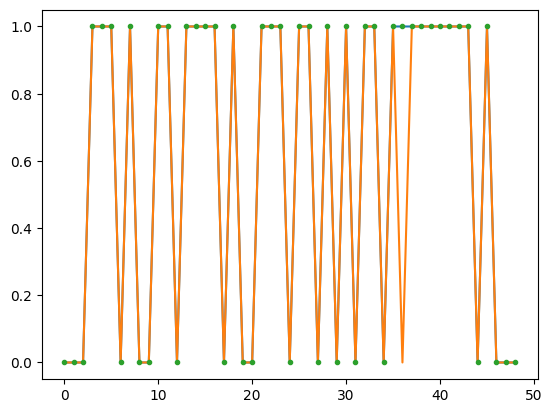

In [11]:
from dataset import EbN0_to_std, ECC_Dataset, bin_to_sign, sign_to_bin
code = config.code 
EbNo_range_train = [5]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
x = x.unsqueeze(0)
y = y.unsqueeze(0)
loss, out = apply_model(model, x, y, syn, 'cuda')
plt.figure()
plt.plot(x[0].numpy())
plt.plot(sign_to_bin(torch.sign(y)[0].numpy()))
plt.plot(out[0].detach().cpu().numpy(),'. ')

torch.Size([49, 49]) torch.Size([28, 49])
torch.Size([49, 49])


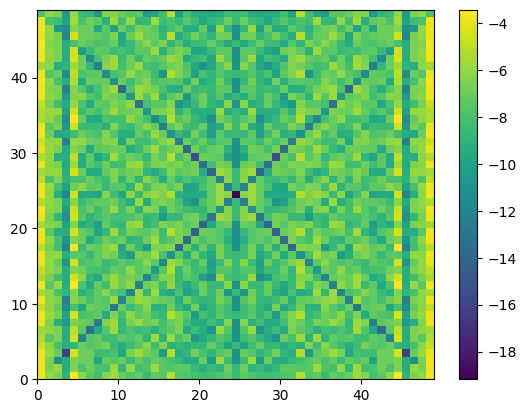

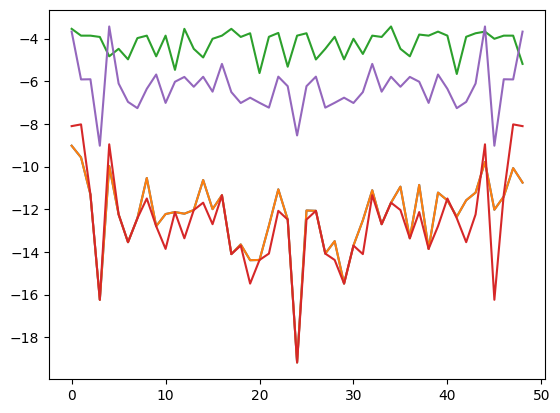

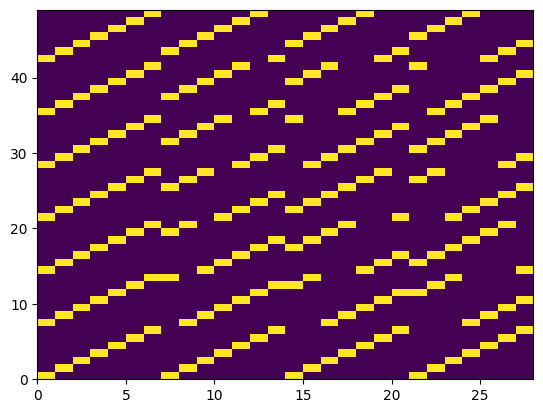

In [12]:
from models.S6CC.utils import get_syndrome


code = config.code 
EbNo_range_train = [10]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]

x = torch.zeros((config.code.n,config.code.n))
y = bin_to_sign(x + torch.eye(config.code.n))
print(y.shape, config.code.pc_matrix.shape)
syn = (sign_to_bin(y) @ config.code.pc_matrix.T.float()) % 2
out = model(torch.abs(y).to('cuda'),syn.to('cuda'))
print(out.shape)
# loss, x_pred = model.loss(out[...,0], sign_to_bin(y).to('cuda'), y.to('cuda'))
# plt.figure()
# plt.pcolormesh(x_pred.detach().cpu().numpy())
model.zero_grad()
plt.figure()
plt.pcolormesh(out.detach().cpu().numpy())
plt.colorbar()
# loss
plt.figure()
plt.plot(out.detach().cpu().numpy().min(1))
plt.plot(out.detach().cpu().numpy().min(1))
plt.plot(out.detach().cpu().numpy().max(1))
plt.plot(out.detach().cpu().numpy().min(0))
plt.plot(out.detach().cpu().numpy().max(0))

plt.figure()
plt.pcolormesh(syn)

In [13]:
out

tensor([[ -3.7606,  -6.0779,  -6.5113,  ...,  -6.5113,  -6.0779,  -3.7606],
        [ -3.8590,  -6.5434,  -5.9043,  ...,  -5.9043,  -6.5434,  -3.8590],
        [ -3.8590,  -6.5923, -11.3060,  ..., -11.3060,  -6.5923,  -3.8590],
        ...,
        [ -3.8590,  -6.0707, -10.9312,  ..., -10.9312,  -6.0707,  -3.8590],
        [ -3.8590,  -8.0193,  -8.2247,  ...,  -8.2247,  -8.0193,  -3.8590],
        [ -8.1017,  -6.0779,  -6.5113,  ...,  -6.5113,  -6.0779,  -8.1017]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [14]:
from models.S6CC.utils import get_syndrome
self = model.mamba[-1]
code = config.code 
EbNo_range_train = [100]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
y = bin_to_sign(x)

X = y.unsqueeze(0).to('cuda')
syn = syn.unsqueeze(0).to('cuda')

print(syn.shape)

X = embed(X, model.pc_matrix, model.x_embedding)
Syn = embed(syn, model.syndrome_connections, model.syn_embedding)

out, out2,A, B, C, states = self._bider_pass(X, Syn)
out += out2
# out, B, C, states = self._forward_pass(X, syn)
# out = self.resize_output(out)

print(out.shape)

torch.Size([1, 28])
torch.Size([1, 49, 28, 16])


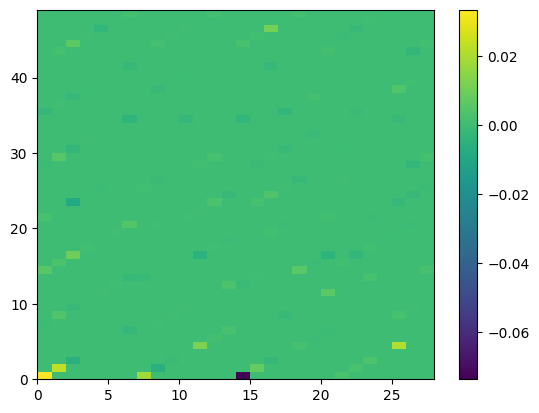

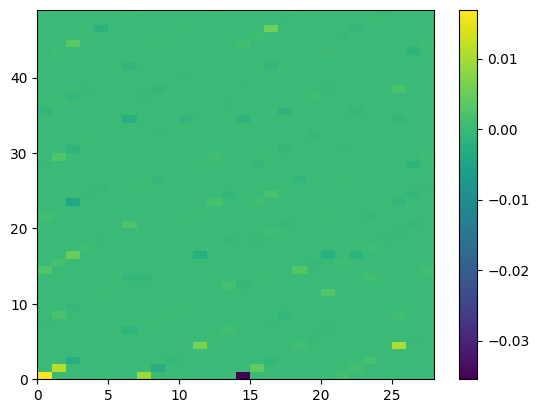

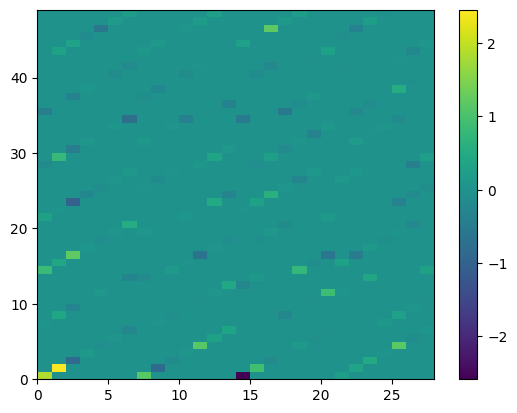

In [15]:
plt.figure()
plt.pcolormesh(out[0,...,0].detach().cpu().numpy())
plt.colorbar()
plt.figure()
plt.pcolormesh(self.activation(out)[0,...,0].detach().cpu().numpy())
plt.colorbar()
plt.figure()
plt.pcolormesh(self.activate(out)[0,...,0].detach().cpu().numpy(),)
plt.colorbar()
out = out[0,:,:,0]

Text(0.5, 1.0, 'errors')

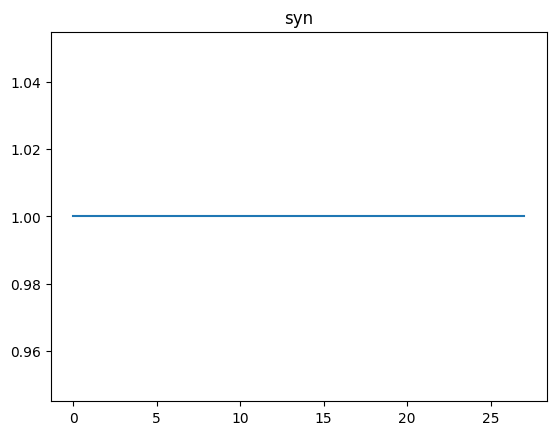

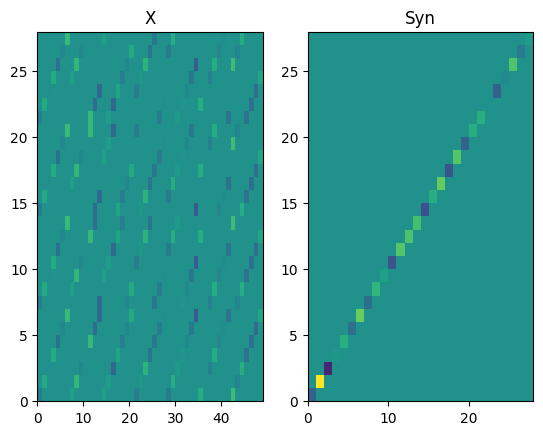

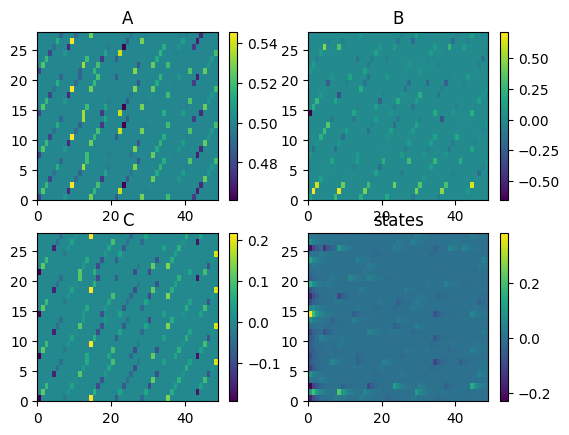

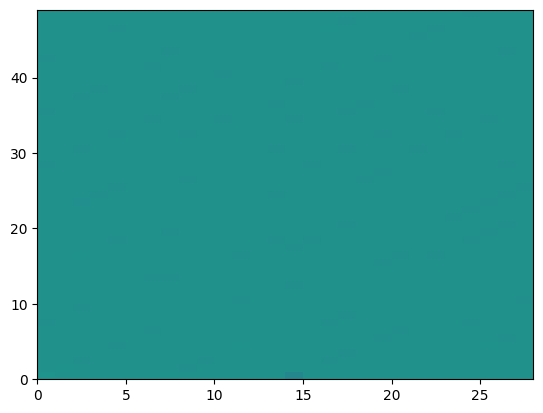

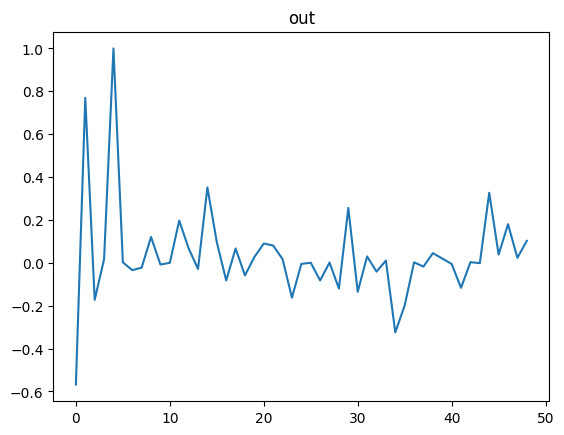

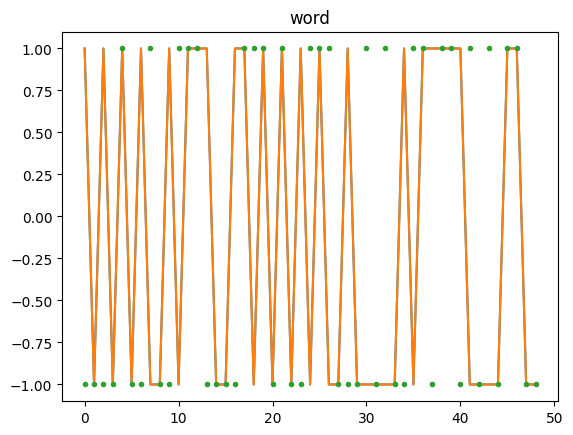

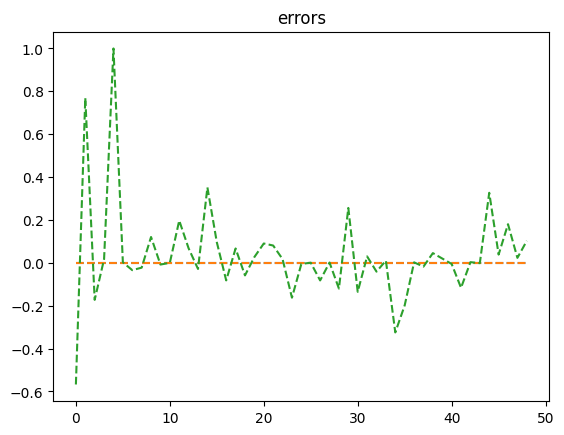

In [16]:


# plt.figure()
# plt.pcolormesh(code.pc_matrix)
plt.figure()
plt.plot(syn[0].detach().cpu().numpy())
plt.title("syn")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.pcolormesh(X[0,:,:,0].detach().cpu().numpy().T,vmin=-1,vmax=1)
ax1.set_title("X")
ax2.pcolormesh(Syn[0,:,:,0].detach().cpu().numpy().T,vmin=-1,vmax=1)
ax2.set_title("Syn")
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2)
pc = ax1.pcolormesh((A)[0,:,:,0].detach().cpu().numpy().T)
ax1.set_title('A')
ax1.figure.colorbar(pc)
pc = ax2.pcolormesh((B[0,:,:,0]).detach().cpu().numpy().T)
ax2.set_title('B')
ax2.figure.colorbar(pc)
pc = ax3.pcolormesh(C[0,:,:,0].detach().cpu().numpy().T)
ax3.set_title('C')
ax3.figure.colorbar(pc)
pc = ax4.pcolormesh((states[0,:,:,0]).detach().cpu().numpy().T,)
ax4.figure.colorbar(pc)
ax4.set_title('states')

plt.figure()
plt.pcolormesh(out.detach().cpu().numpy(), vmin=-1,vmax=1)

dout = out.sum(dim=-1)
dout = dout.detach().cpu()/(dout.detach().cpu().numpy().max()+1e-10)
# out2 = out2[0,...,0].detach().cpu()/(out2.detach().cpu().numpy().max()+1e-10)
plt.figure()
plt.plot(dout)
# plt.plot(out2, ls="--")
# plt.plot(torch.sign(dout))
plt.title("out")
plt.figure()
line_x, = plt.plot(bin_to_sign(x))
line_y, = plt.plot(y)
line_out, = plt.plot(torch.sign(dout)*y, '. ')
plt.title("word")

plt.figure()
plt.plot((x!=0) ^ (y<0), c=line_x.get_color(), ls="--")
plt.plot((y * bin_to_sign(x)) < 0, c=line_y.get_color(), ls="--")
line_out, = plt.plot(dout, c=line_out.get_color(), ls="--")
plt.title("errors")


,grad_norm
mamba.0.out_proj.bias,3.090838
mamba.1.C_weights,1.144458
mamba.1.in_proj.weight,0.882228
resize_output_dim.weight,0.870780
mamba.1.B_weights,0.567998
...,...
mamba.5.syn_h_weights,0.000027
mamba.4.syn_h_weights,0.000022
mamba.7.syn_h_weights,0.000021
mamba.6.syn_h_weights,0.000010


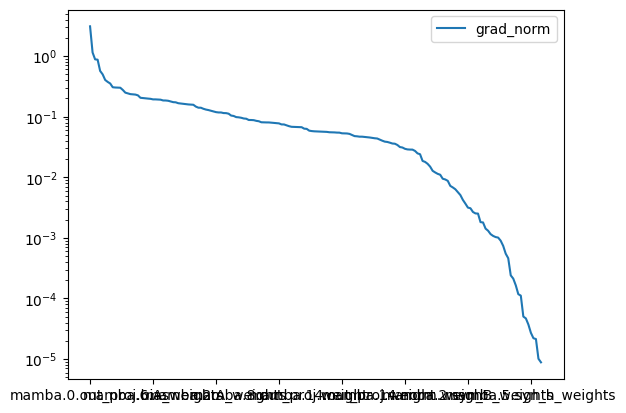

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
EbNo_range_train = [3]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
model.zero_grad()
loss, x_pred = apply_model(model, x.unsqueeze(0), y.unsqueeze(0), syn.unsqueeze(0),'cuda')
loss.backward()
gradient_norms = {}

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_norms[name] = param.grad.norm().item()
df = pd.DataFrame(gradient_norms.values(), index=gradient_norms.keys(),columns=["grad_norm"]).sort_values("grad_norm", ascending=False)
df.plot()
plt.yscale("log")
df


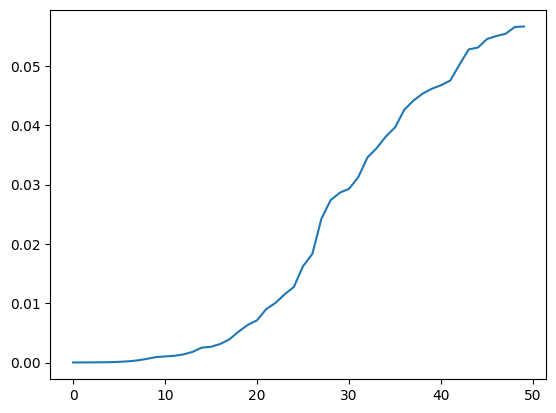

In [18]:
plt.figure()
plt.plot(np.arange(50),np.percentile(df.grad_norm, np.arange(50)))